In [38]:
import numpy as np
import matplotlib.pyplot as plt

In [39]:
# Load gauge data
from DSS_analyzer_Mariner import Data1D_GAUGE
datapath = "./"
gauge_data_folder = datapath + "s_well/gauge_data/"
gauge_dataframe = Data1D_GAUGE.Data1D_GAUGE(gauge_data_folder + f"gauge6_data_swell.npz")

In [40]:
# Plot the gauge data
from DSS_analyzer_Mariner import Data1D_PumpingCurve
pumping_curve_filepath = datapath + f"prod/pumping_curve/pumping_curve_stage7.npz"
pumping_curve = Data1D_PumpingCurve.Data1D_PumpingCurve(pumping_curve_filepath)

In [41]:
# Crop the pressure gauge data,
start_time = pumping_curve.get_start_time()
end_time = pumping_curve.get_end_time()
gauge_dataframe.crop(start_time, end_time)

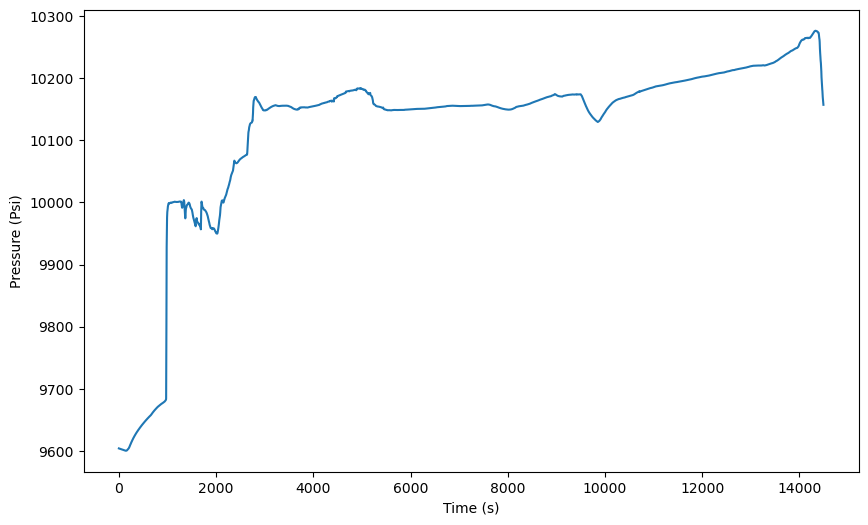

In [42]:
gauge_taxis = gauge_dataframe.calculate_time()
plt.figure(figsize=(10, 6))
plt.plot(gauge_taxis * 3600, gauge_dataframe.data)
plt.xlabel("Time (s)")
plt.ylabel("Pressure (Psi)")
plt.show()

In [43]:
gauge_md_index = np.array([ 265,  520,  789, 1043, 1312, 1567])
frac_hit_index = np.array([589, 830])

In [44]:
nx = 1600
total_time = 1300
d = 140 * np.ones(nx)

dx = 1

In [45]:
x = np.arange(0, nx*dx, dx)

In [46]:
u_snapshot = [] # store the snapshot of u
u_current = np.zeros(nx)
t = list([0]) # store the time points
dt = 0
dt_init = 1.0

In [47]:
# Interpolate the gauge data for any time point, the function would return the interpolated value
from scipy.interpolate import interp1d
def interpolate_gauge_data(time):
    gauge_data = gauge_dataframe.data
    gauge_taxis = gauge_dataframe.calculate_time()
    gauge_interpolator = interp1d(gauge_taxis * 3600, gauge_data, kind='linear')
    return gauge_interpolator(time)

In [48]:
# phase 1: stage 1 (7 in the original data)
def build_matrix_phase1(dt):
    alpha = d * dt / dx**2
    
    A = np.zeros((nx, nx))
    
    for i in range(1, nx-1):
        A[i, i-1] = -alpha[i]
        A[i, i] = 1 + 2 * alpha[i]
        A[i, i+1] = -alpha[i]
    
    A[0, 0] = 1
    A[-1, -1] = 1
    A[0, 1] = -1
    A[-1, -2] = -1
    
    # Source term
    A[frac_hit_index[0], :] = 0
    A[frac_hit_index[0], frac_hit_index[0]] = 1
    
    return A

def build_rhs_phase1(u_current, t):
    rhs = u_current.copy()
    rhs[0] = 0
    rhs[-1] = 0
    # source term
    rhs[frac_hit_index[0]] = interpolate_gauge_data(t)
    print(f"Time: {t}, Source: {interpolate_gauge_data(t)}")
    return rhs

In [49]:
u_current = gauge_dataframe.data[0] * np.ones_like(u_current) # initial condition
u_snapshot.append(u_current.copy())

In [50]:
def full_step_phase1(u_current, dt, t):
    A = build_matrix_phase1(dt)
    rhs = build_rhs_phase1(u_current, t)
    return np.linalg.solve(A, rhs)

In [51]:
# test the full step
dt = dt_init

u_current = full_step_phase1(u_current, dt, t[-1])
u_snapshot.append(u_current.copy())
t.append(t[-1] + dt)

Time: 0, Source: 9604.148


In [52]:
# half step
def half_step_phase1(u_current, dt, t):
    dt_half = dt / 2
    A_half = build_matrix_phase1(dt_half)
    rhs_half = build_rhs_phase1(u_current, t)
    u_middle = np.linalg.solve(A_half, rhs_half)
    
    b_half = build_rhs_phase1(u_middle, t)
    u_final = np.linalg.solve(A_half, b_half)
    
    return u_final

In [53]:
# test the half step
u_current_half = half_step_phase1(u_current, dt, t[-1])

Time: 1.0, Source: 9604.108172613309
Time: 1.0, Source: 9604.108172613309


In [54]:
# calculate the error
np.linalg.norm(u_current_half - u_current) / np.linalg.norm(u_current)

3.8255371840467325e-07

In [55]:
def adjust_dt(dt_current, error, tol=1e-3):
    safety_factor = 0.9
    p = 2
    
    dt_new = safety_factor * dt_current * (tol / max(error, 1e-16))**(1/(p+1))
    
    dt_new = min(2.0 * dt_init, max(0.5 * dt_current, dt_new))
    
    return dt_new

In [56]:
while t[-1] < total_time:
    # calculate the full step
    u_current = full_step_phase1(u_current, dt, t[-1])
    
    # calculate the half step
    u_current_half = half_step_phase1(u_current, dt, t[-1])
    
    # calculate the error
    error = np.linalg.norm(u_current_half - u_current) / np.linalg.norm(u_current)
    # print(f"Time: {t[-1]}, Error: {error}")
    # adjust the time step
    dt = adjust_dt(dt, error)
    
    if error <= 1e-3:
        # store the snapshot
        u_snapshot.append(u_current.copy())
        t.append(t[-1] + dt)
        
        # update the time step
        dt = min(dt, 4)
    else:
        dt = max(0.5 * dt, 0.1)
    
    # store the snapshot
    u_snapshot.append(u_current.copy())
    t.append(t[-1] + dt)

Time: 1.0, Source: 9604.108172613309
Time: 1.0, Source: 9604.108172613309
Time: 1.0, Source: 9604.108172613309
Time: 5.0, Source: 9603.99223720223
Time: 5.0, Source: 9603.99223720223
Time: 5.0, Source: 9603.99223720223
Time: 9.0, Source: 9603.895155358898
Time: 9.0, Source: 9603.895155358898
Time: 9.0, Source: 9603.895155358898
Time: 13.0, Source: 9603.778548786528
Time: 13.0, Source: 9603.778548786528
Time: 13.0, Source: 9603.778548786528
Time: 17.0, Source: 9603.683039738431
Time: 17.0, Source: 9603.683039738431
Time: 17.0, Source: 9603.683039738431
Time: 21.0, Source: 9603.565576070901
Time: 21.0, Source: 9603.565576070901
Time: 21.0, Source: 9603.565576070901
Time: 25.0, Source: 9603.46762035225
Time: 25.0, Source: 9603.46762035225
Time: 25.0, Source: 9603.46762035225
Time: 29.0, Source: 9603.349659346271
Time: 29.0, Source: 9603.349659346271


KeyboardInterrupt: 

In [ ]:
# plot the results
plt.figure(figsize=(10, 6))
plt.imshow(np.array(u_snapshot).T, aspect='auto', cmap='bwr', extent=[0, t[-1], 0, nx*dx])
plt.colorbar()
plt.xlabel("Time (s)")
plt.ylabel("Distance (m)")
plt.show()